# Imports

In [5]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer



import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [6]:
df = pd.read_csv('./fin_df_103019.csv')

In [7]:
df.head()

,text,hashtags,user_name,date,user_location,label
0,Congrats pre,NaN,MasterAR9012502,2019-10-24 15:05:01+00:00,NaN,0
1,Wassup?,NaN,theprejon,2019-10-21 20:54:33+00:00,NaN,0
2,"Ini mbc korea yang komen orang indo semueh,, b...",NaN,KhoyrR,2019-10-24 14:19:01+00:00,NaN,0
3,Meron pre?,NaN,Zendriccccc,2019-10-26 13:00:29+00:00,NaN,0
4,this is their pre-p3p5 fam love story thanks,NaN,akihikologist,2019-10-21 02:44:47+00:00,NaN,0


In [8]:
df.shape

(2728, 6)

In [9]:
df.isnull().sum()

text                1
hashtags         1315
user_name           0
date                3
user_location    2726
label               0
dtype: int64

In [10]:
df['label'].value_counts()

0    1840
1     804
2      84
Name: label, dtype: int64

**Dropped rows where label == 2**

Since label == 2 may or may not be relevant

In [11]:
df = df[df['label']!=2]

In [12]:
df['label'].value_counts()

0    1840
1     804
Name: label, dtype: int64

**Cleaning date column**

Dropped the rows with null dates

In [13]:
df.head()

,text,hashtags,user_name,date,user_location,label
0,Congrats pre,NaN,MasterAR9012502,2019-10-24 15:05:01+00:00,NaN,0
1,Wassup?,NaN,theprejon,2019-10-21 20:54:33+00:00,NaN,0
2,"Ini mbc korea yang komen orang indo semueh,, b...",NaN,KhoyrR,2019-10-24 14:19:01+00:00,NaN,0
3,Meron pre?,NaN,Zendriccccc,2019-10-26 13:00:29+00:00,NaN,0
4,this is their pre-p3p5 fam love story thanks,NaN,akihikologist,2019-10-21 02:44:47+00:00,NaN,0


In [14]:
df['text'] = df['text'].fillna("").copy()

In [15]:
df = df.drop('user_location', axis =1)

In [16]:
df.head()

,text,hashtags,user_name,date,label
0,Congrats pre,NaN,MasterAR9012502,2019-10-24 15:05:01+00:00,0
1,Wassup?,NaN,theprejon,2019-10-21 20:54:33+00:00,0
2,"Ini mbc korea yang komen orang indo semueh,, b...",NaN,KhoyrR,2019-10-24 14:19:01+00:00,0
3,Meron pre?,NaN,Zendriccccc,2019-10-26 13:00:29+00:00,0
4,this is their pre-p3p5 fam love story thanks,NaN,akihikologist,2019-10-21 02:44:47+00:00,0


In [17]:
df.head()

,text,hashtags,user_name,date,label
0,Congrats pre,NaN,MasterAR9012502,2019-10-24 15:05:01+00:00,0
1,Wassup?,NaN,theprejon,2019-10-21 20:54:33+00:00,0
2,"Ini mbc korea yang komen orang indo semueh,, b...",NaN,KhoyrR,2019-10-24 14:19:01+00:00,0
3,Meron pre?,NaN,Zendriccccc,2019-10-26 13:00:29+00:00,0
4,this is their pre-p3p5 fam love story thanks,NaN,akihikologist,2019-10-21 02:44:47+00:00,0


# date time function

In [18]:
def clean_time(df, column="date"):
    #drop rows with no date information 
    df = df.dropna(subset=["date"])
    
    #split day and time information
    df["split_date"] = df["date"].str.split("-")
    
    #pull out month and make column
    df["month"] = df["split_date"].str.get(1).astype(int)
    #pull out day/time information
    df["time"] = df["split_date"].str.get(2)
    #split day from time on space
    df["time_split"] = df["time"].str.split(" ")
    #pull out day
    df["day"] = df["time_split"].str.get(0).astype(int)
    #now look at time
    df["time_col"] = df["time_split"].str.get(1)
    #split on + to separate out time from timezone
    df["hour_min_sec"] = df["time_col"].str.split("+")
    #all timezones are assumed to be GMT so ignoring and focusing on time
    df["hour_min_sec"] = df["hour_min_sec"].str.split(":")
    df["hour"] = df["hour_min_sec"].str.get(0).astype(int)
    df["minute"] = df["hour_min_sec"].str.get(1).astype(int)
    df["second"] = df["hour_min_sec"].str.get(2).astype(int)
    #dropping temp columns I made
    df = df.drop(columns=["date", "split_date", "time", "time_split", "time_col", "hour_min_sec"])
    return df
  

**Funtion that checks which dataframe a word belongs to**

In [19]:
def what_post(dataframe, word):
    """
    Return rows of 'orig_df' that 'word' is included in text
    
    Parameters
    word: str or list
    """
    if type(word) == str:
        return dataframe[(dataframe['text'].str.contains(word))]
    if type(word) == list:
        return dataframe[dataframe['text'].str.contains('|'.join(word))]

# Stop Words
Removed obvious stop words 

In [20]:
custom_stop = list(ENGLISH_STOP_WORDS)
custom_stop.extend(['fire', 'firefighters', 'twitter', 'pic', 'www', 'http', 'https',
                    'com', 'ho', 'bad', 'new', 'round', '3a', 'trueanthem', 'content', 'content_utm',
                    'wildfire', 'busted', 'burns', 'patch', 'california', 'utm_campaign',
                   'massive', 'haunted', 'remains'])


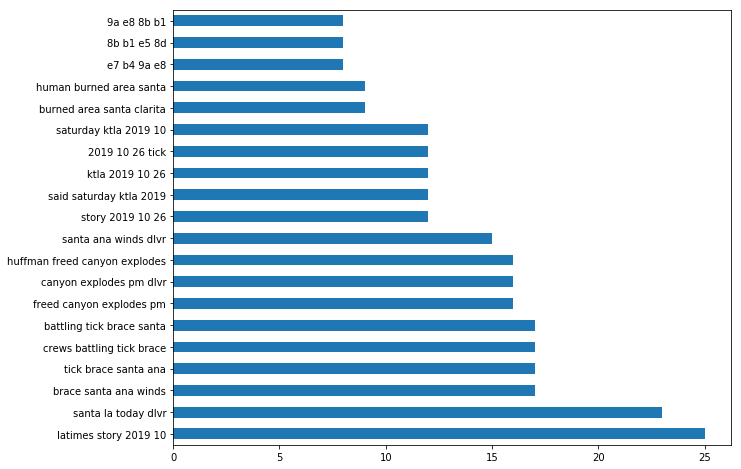

In [21]:
cv = CountVectorizer(stop_words=custom_stop, ngram_range =(4,4), min_df= 2)
text_ft_sw= cv.fit_transform(df['text'])
text_df_sw= pd.DataFrame(text_ft_sw.toarray(), columns=cv.get_feature_names())
text_df_sw.sum().sort_values(ascending=False).head(20).plot(kind='barh', figsize= (10,8));


**Perform a split of our `X` and `y`.**

-`Performing train/test splits using scikit-learn `

-`Setting the random state at 740`

In [22]:
X = df['text']
y = df['label']

random_state = 740

X_train,X_test, y_train,y_test = train_test_split(X, y)


# Logistic Regression : TF- IDF

**Searching for best hyperparameters using Gridsearch**

| Argument | Description |
| --- | ---|
| **`penalty`** | Used to specify the norm used in the penalization  |
| **`n_gram_range`** | The lower and upper boundary of the range of n-values for different n-grams to be extracted. |
| **`stop_words`** | List is assumed to contain stop words, all of which will be removed from the resulting tokens. |
| **`max_df`** | When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold  |
| **`min_df`** | When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. |
| **`analyzer`** | Whether the feature should be made of word or character n-grams. |
| **`max_features`** | Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus |

**Building pipeline before Gridsearching**

In [24]:
pipe = Pipeline([('tfidf', TfidfVectorizer()),
                 ('logreg', LogisticRegression( penalty = 'l2'))
                ])

In [25]:
pipe_params = {
    'tfidf__ngram_range' :[(1,1)],
    'tfidf__stop_words' :[custom_stop],
    'tfidf__max_df':[.8],
    'tfidf__min_df' :[3,4,5,6,7],
    'tfidf__analyzer': ['word'],
    'tfidf__max_features':[5000, 3000, 2000]
    
}

**Using TF-IDF Logistic Regression Model our scores are:**

`Training score`: 0.8895612708018155

`Testing score`: 0.8608169440242057

In [26]:
gs = GridSearchCV(pipe, pipe_params, cv = 5)
gs.fit(X_train, y_train)
gs.score(X_train,y_train)

/Users/jk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

/Users/jk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

0.8895612708018155

In [27]:
gs.score(X_test,y_test)

0.8608169440242057

**Best Parameters from our Gridsearch**

In [251]:
gs.best_params_

{'tfidf__analyzer': 'word',
 'tfidf__max_df': 0.8,
 'tfidf__max_features': 5000,
 'tfidf__min_df': 6,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': ['amongst',
  'etc',
  'they',
  'hereby',
  'top',
  'last',
  'but',
  'somehow',
  'to',
  'much',
  'nor',
  'out',
  'he',
  'herein',
  'rather',
  'further',
  'been',
  'will',
  'here',
  'perhaps',
  'meanwhile',
  'until',
  'seeming',
  'her',
  'fifty',
  'him',
  'between',
  'had',
  'call',
  'everything',
  'we',
  'ie',
  'our',
  'thereby',
  'was',
  'keep',
  'same',
  'you',
  'are',
  'whose',
  'more',
  'through',
  'whither',
  'without',
  'from',
  'become',
  'hasnt',
  'three',
  'yourself',
  'since',
  'amount',
  'alone',
  'system',
  'all',
  'co',
  'very',
  'both',
  'wherein',
  'thus',
  'even',
  'found',
  'someone',
  'two',
  'itself',
  'however',
  'cant',
  'none',
  'with',
  'latter',
  'whoever',
  'four',
  'whereas',
  'due',
  'side',
  'indeed',
  'others',
  'because',
  'after',

In [1]:
#what_score(gs.best_estimator_, X, y)

In [28]:
def what_score(your_model, your_X, your_y):
    """
    Return train score, test score, cv score
    
    Parameter:
    your_model: estimator
    your X: X
    your y: y
    """
    X_train, X_test, y_train, y_test = train_test_split(your_X,your_y, random_state = 740)
    train_score = your_model.score(X_train, y_train)
    test_score = your_model.score(X_test, y_test)
    cv_score = cross_val_score(your_model, X_train, y_train, cv = 5).mean()
    
#     pd.DataFrame({'train': train_score, 'test': test_score, 'cv': cv_score})
    
    return {'train': train_score, 'test':test_score, "cv score": cv_score}

In [29]:
def coef_df(gridsearch_model, X_train, y_train ,vect_str = 'cvec', reg_str = 'lr' ):
    """
    Return a dataframe with columns
        1. words
        2. coefficient weight (log odd)
        3. exponent of coefficient weight (odd)
    from a gridsearch model with a vectorizer and a logistic regression.
    
    """

    col_names = gridsearch_model.best_estimator_.named_steps[vect_str].get_feature_names()
    col_coef = gridsearch_model.best_estimator_.named_steps[reg_str].coef_[0]

    cvec_coef_df = pd.DataFrame({
        'words' : col_names,
        'coef' : col_coef,
        'exp_coef': np.exp(col_coef)    
    })
    
    return pd.DataFrame(cvec_coef_df)

In [35]:
#coef_tfidf = coef_df(gs, X_train, y_train ,vect_str = 'tfidf', reg_str = 'logreg' )

In [34]:
#coef_tfidf['coef'].value_counts()

**Using a function to get the best estimators (CONFUSION METRICS) from our Gridsearch above**

`Training score`: 0.8784669692385275

`Testing score`: 0.8940998487140696

`cv score` : 0.8300676793120119

`Sensitivity` : 0.6931216931216931

`Specificity` : 0.9745762711864406




In [37]:
what_score(gs.best_estimator_, X, y)

/Users/jk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

{'train': 0.8784669692385275,
 'test': 0.8940998487140696,
 'cv score': 0.8300676793120119,
 'sensitivity': 0.6931216931216931,
 'specificity': 0.9745762711864406}

# Random Forest : TF- IDF

**Searching for best hyperparameters using Gridsearch**

| Argument | Description |
| --- | ---|
| **`penalty`** | Used to specify the norm used in the penalization  |
| **`n_gram_range`** | The lower and upper boundary of the range of n-values for different n-grams to be extracted. |
| **`stop_words`** | List is assumed to contain stop words, all of which will be removed from the resulting tokens. |
| **`max_df`** | When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold  |
| **`min_df`** | When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. |
| **`analyzer`** | Whether the feature should be made of word or character n-grams. |
| **`max_features`** | Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus |
| **`n_estimators`** | The number of trees in the forest. |
| **`max_depth`** | The maximum depth of the tree. |


In [38]:
pipe_2 = Pipeline([('tfidf', TfidfVectorizer()),
                 ('rf', RandomForestClassifier())
                ])


pipe_params_2 = {
    'tfidf__ngram_range' :[(1,1)],
    'tfidf__stop_words' :[custom_stop],
    'tfidf__max_df':[.8],
    'tfidf__min_df' :[3,4,5,6,7],
    'tfidf__analyzer': ['word'],
    'tfidf__max_features':[5000, 3000, 2000],
    'rf__n_estimators':[10, 100, 300],
    'rf__max_depth' : [4, 5, 6],
    
}




In [39]:
gs_2 = GridSearchCV(pipe_2, param_grid = pipe_params_2, cv = 5)

In [40]:
gs_2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

**Using a function to get the best estimators (CONFUSION METRICS) from our Gridsearch above**

`Training score`: 

`Testing score`: 

`cv score` : 

`Sensitivity` : 

`Specificity` : 

In [41]:
what_score(gs_2.best_estimator_, X, y)

{'train': 0.7750882501260716,
 'test': 0.7866868381240545,
 'cv score': 0.7584459201587666,
 'sensitivity': 0.2751322751322751,
 'specificity': 0.9915254237288136}

In [274]:
def what_important(rf_model, X_rf):
    """
    parameter:
    rf_model: Your random forest model [ex) rf_model = RandomForestClassifier()]
    X_rf: 'X' you used to fit your 'rf_model
    """
    out = {'features': X_rf.columns,
           'importance': rf_model.feature_importances_}
    return pd.DataFrame(out).sort_values(by = 'importance', ascending = False)